# Feb 1st, 2022 (small memship vote)

**Motivation**: Node membership: remove small values based on a voting mechanism.  Results for animals and group. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(
        1, 4, (10., 2), width_ratios=[1.7, 1, 1, 1.7])

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}

## Prepare

In [4]:
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p10-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Membership plot

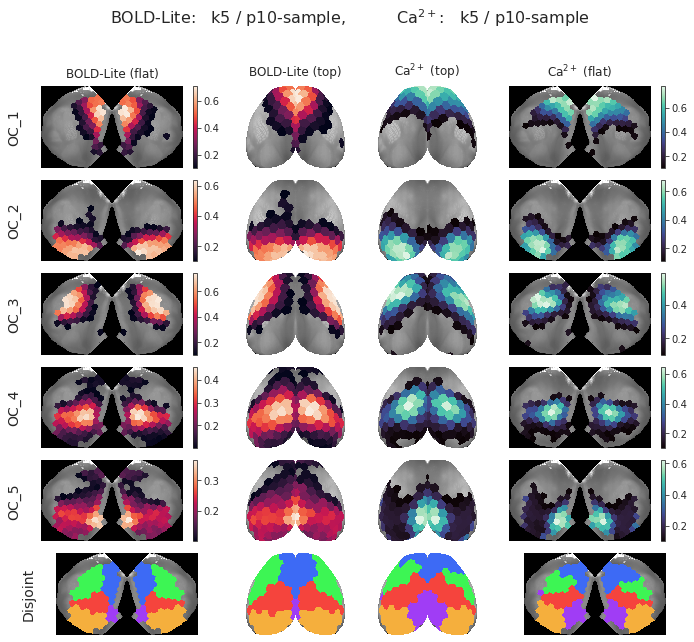

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [6]:
gr_bold.pi_symmetry_score(decimals=5)

(
    {1: 0.99369, 2: 0.99514, 3: 0.99294, 4: 0.99334, 5: 0.99632, -1: 0.99428},
    {1: 0.97701, 2: 0.98851, 3: 0.96552, 4: 0.97701, 5: 1.0, -1: 0.98161}
)

In [7]:
gr_ca.pi_symmetry_score(decimals=5)

(
    {1: 0.98681, 2: 0.99326, 3: 0.97899, 4: 0.99218, 5: 0.98576, -1: 0.9874},
    {1: 0.91954, 2: 0.98851, 3: 0.89655, 4: 0.95402, 5: 0.98851, -1: 0.94943}
)

## Node vote plots

### Ca2

In [8]:
i, j, k = gr_ca.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=10000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)

In [9]:
votes_dict = gr_ca.cast_votes(se_anim, 0.99, 0.01)

#### Apply vote: per animal

In [10]:
pi_prune = dc(gr_ca.run_pi)
for node in gr_ca.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

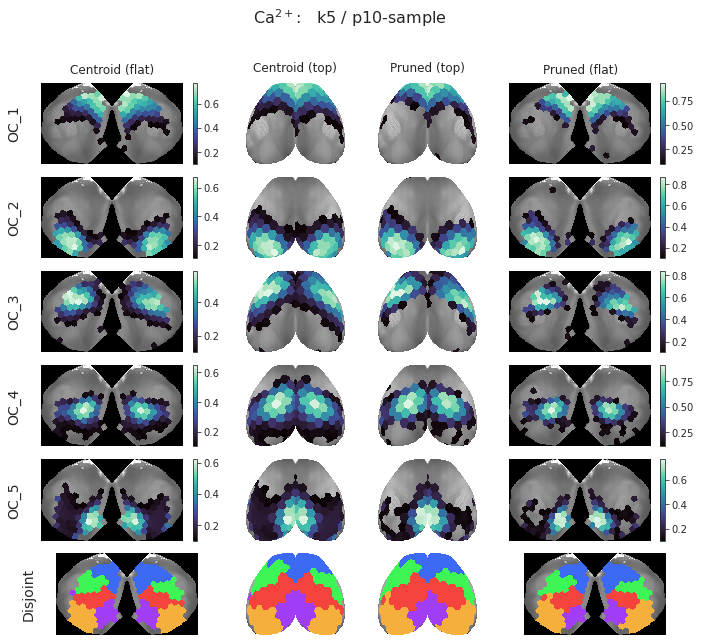

In [11]:
fig, _ = gr_ca.show(
    proj_ca, gr_ca.project_vec(pi_prune_avg),
    labels=('Centroid', 'Pruned'),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [12]:
gr_ca.pi_symmetry_score(decimals=3)

(
    {1: 0.987, 2: 0.993, 3: 0.979, 4: 0.992, 5: 0.986, -1: 0.987},
    {1: 0.92, 2: 0.989, 3: 0.897, 4: 0.954, 5: 0.989, -1: 0.949}
)

In [13]:
gr_ca.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.966, 2: 0.985, 3: 0.93, 4: 0.97, 5: 0.97, -1: 0.964},
    {1: 0.92, 2: 0.977, 3: 0.897, 4: 0.931, 5: 0.954, -1: 0.936}
)

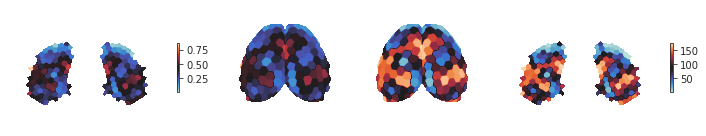

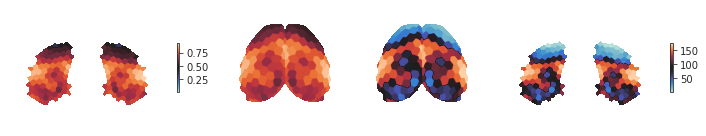

In [14]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_ca.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_ca.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False),
    gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False),
)

In [15]:
kk, nn = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], kk, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)

In [16]:
cut_avg

array([[18.68087411, 14.92746722, 15.13670361, 51.25495506],
       [23.41152007, 16.85555495, 19.5687342 , 40.16419077],
       [25.25799944, 18.65467585, 16.33491499, 39.75240972],
       [27.71473951, 21.0366913 , 19.36391252, 31.88465668],
       [31.33323499, 17.17362767, 12.60431056, 38.88882679]])

In [17]:
gr_ca.grp_cut

memmap([[27.27210535, 20.36025282, 22.9098823 , 29.45775953],
        [32.99400881, 19.80615903, 25.40967054, 21.79016162],
        [36.18535592, 23.68444197, 23.71037431, 16.41982779],
        [38.84533509, 26.27109344, 24.04243461, 10.84113686],
        [34.49888038, 19.08804767, 21.03779858, 25.37527338]])

#### Apply vote: majority

In [18]:
pi_prune = dc(gr_ca.run_pi)
for node in gr_ca.n2l:
    vote = votes_dict['votes_majority'][node]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, i, axis=0)
    vote = np.repeat(vote, j, axis=1)
    vote = np.repeat(vote, k, axis=2)
    pi_prune[..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

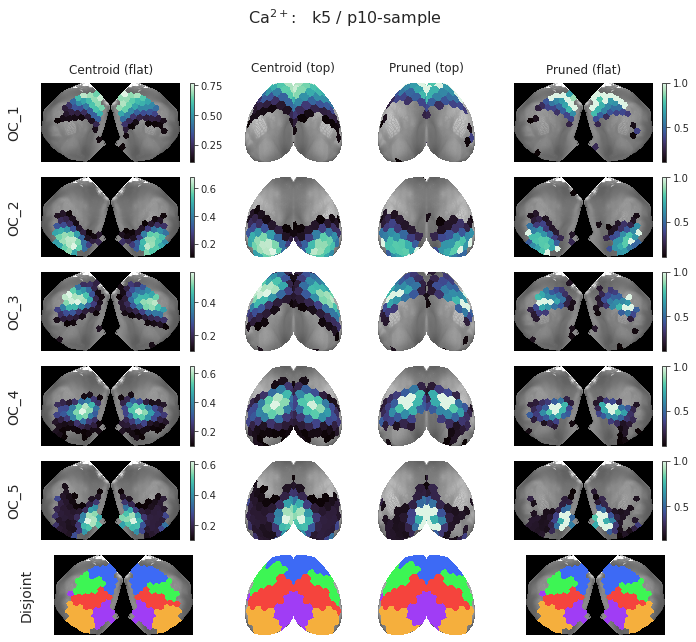

In [19]:
fig, _ = gr_ca.show(
    proj_ca, gr_ca.project_vec(pi_prune_avg),
    labels=('Centroid', 'Pruned'),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [20]:
gr_ca.pi_symmetry_score(decimals=3)

(
    {1: 0.987, 2: 0.993, 3: 0.979, 4: 0.992, 5: 0.986, -1: 0.987},
    {1: 0.92, 2: 0.989, 3: 0.897, 4: 0.954, 5: 0.989, -1: 0.949}
)

In [21]:
gr_ca.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.934, 2: 0.955, 3: 0.862, 4: 0.955, 5: 0.956, -1: 0.932},
    {1: 0.92, 2: 0.989, 3: 0.897, 4: 0.966, 5: 0.977, -1: 0.949}
)

In [22]:
kk, nn = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], kk, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)

In [23]:
cut_avg

array([[16.53875804, 13.28161752, 15.88847003, 54.29115441],
       [21.89523146, 17.31150213, 19.90355897, 40.88970744],
       [24.20800096, 17.53318389, 16.73034246, 41.52847269],
       [25.52279149, 21.55228474, 18.47742401, 34.44749976],
       [26.73354428, 15.50141882, 10.48935217, 47.27568473]])

In [24]:
gr_ca.grp_cut

memmap([[27.27210535, 20.36025282, 22.9098823 , 29.45775953],
        [32.99400881, 19.80615903, 25.40967054, 21.79016162],
        [36.18535592, 23.68444197, 23.71037431, 16.41982779],
        [38.84533509, 26.27109344, 24.04243461, 10.84113686],
        [34.49888038, 19.08804767, 21.03779858, 25.37527338]])

### BOLD-Lite

In [25]:
i, j, k = gr_bold.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_bold.run_pi,
    n_resamples=10000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)

In [26]:
votes_dict = gr_bold.cast_votes(se_anim, 0.99, 0.01)

#### Apply vote: per animal

In [27]:
pi_prune = dc(gr_bold.run_pi)
for node in gr_bold.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

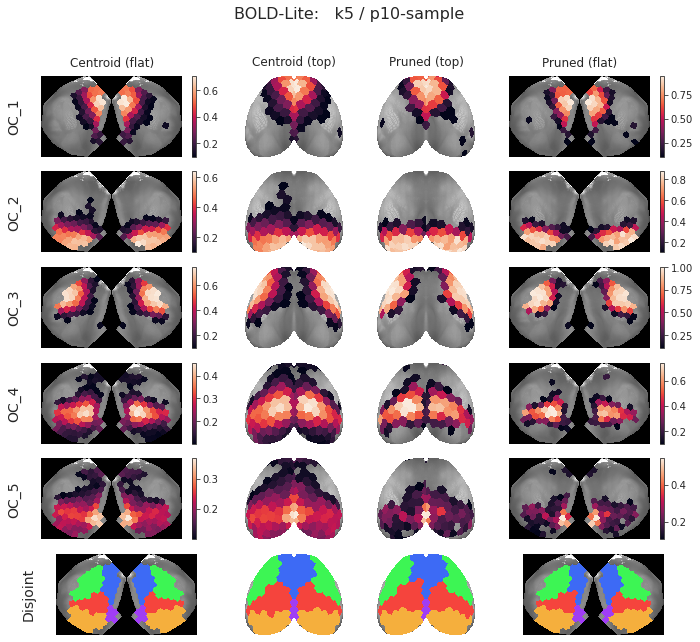

In [28]:
fig, _ = gr_bold.show(
    proj_bold, gr_bold.project_vec(pi_prune_avg),
    labels=('Centroid', 'Pruned'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = r"BOLD-Lite:   " + f"k{props_bold.get('num_k')} / {props_bold.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [29]:
gr_bold.pi_symmetry_score(decimals=3)

(
    {1: 0.994, 2: 0.995, 3: 0.993, 4: 0.993, 5: 0.996, -1: 0.994},
    {1: 0.977, 2: 0.989, 3: 0.966, 4: 0.977, 5: 1.0, -1: 0.982}
)

In [30]:
gr_bold.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.977, 2: 0.992, 3: 0.991, 4: 0.974, 5: 0.967, -1: 0.98},
    {1: 0.966, 2: 0.977, 3: 0.966, 4: 0.966, 5: 0.989, -1: 0.972}
)

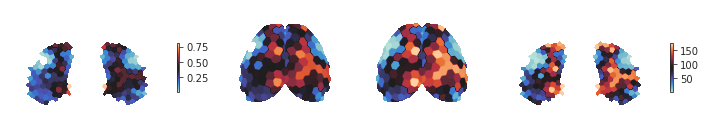

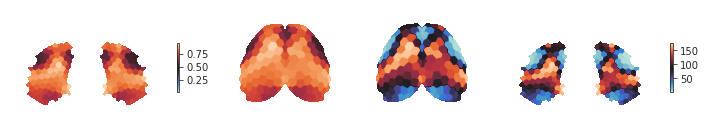

In [31]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_bold.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_bold.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False),
    gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False),
)

In [32]:
kk, nn = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], kk, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)

In [33]:
cut_avg

array([[18.71982634, 13.8754122 , 13.79817607, 53.60658539],
       [17.99913436, 11.666398  , 12.29650089, 58.03796675],
       [16.83700154,  9.98195041,  8.94286975, 64.2381783 ],
       [27.85591799, 18.44212475, 16.99100288, 36.71095439],
       [37.33192761, 20.40029662, 16.0661241 , 26.20165167]])

In [34]:
gr_bold.grp_cut

memmap([[34.49658913, 21.72096749, 19.23802105, 24.54442233],
        [30.71334124, 18.87001928, 23.24186342, 27.17477606],
        [32.37820525, 17.09529263, 20.24083112, 30.28567099],
        [44.97095059, 24.82730091, 19.47182073, 10.72992777],
        [46.51726915, 25.54219308, 19.26450682,  8.67603096]])

#### Apply vote: majority

In [35]:
pi_prune = dc(gr_bold.run_pi)
for node in gr_bold.n2l:
    vote = votes_dict['votes_majority'][node]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, i, axis=0)
    vote = np.repeat(vote, j, axis=1)
    vote = np.repeat(vote, k, axis=2)
    pi_prune[..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

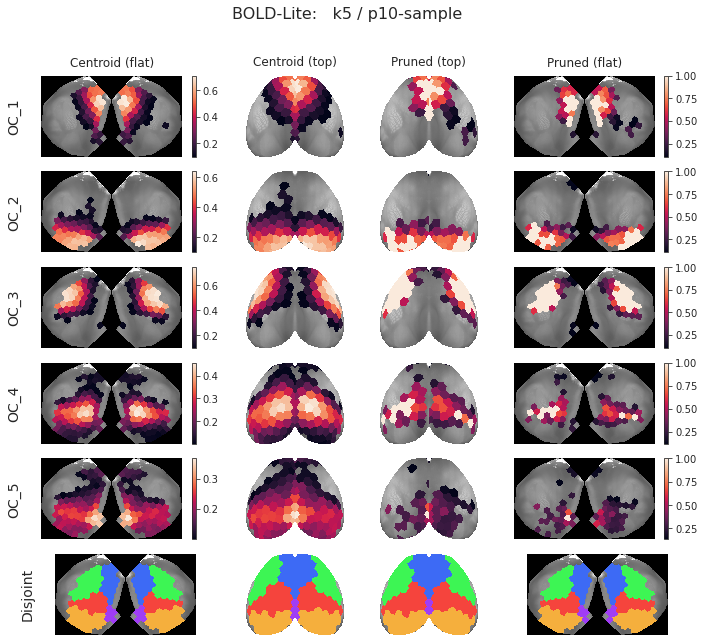

In [36]:
fig, _ = gr_bold.show(
    proj_bold, gr_bold.project_vec(pi_prune_avg),
    labels=('Centroid', 'Pruned'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = r"BOLD-Lite:   " + f"k{props_bold.get('num_k')} / {props_bold.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [37]:
gr_bold.pi_symmetry_score(decimals=3)

(
    {1: 0.994, 2: 0.995, 3: 0.993, 4: 0.993, 5: 0.996, -1: 0.994},
    {1: 0.977, 2: 0.989, 3: 0.966, 4: 0.977, 5: 1.0, -1: 0.982}
)

In [38]:
gr_bold.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.949, 2: 0.938, 3: 0.971, 4: 0.792, 5: 0.797, -1: 0.889},
    {1: 0.989, 2: 0.977, 3: 0.989, 4: 0.977, 5: 1.0, -1: 0.986}
)

In [39]:
kk, nn = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], kk, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)

In [40]:
cut_avg

array([[15.29172779, 12.30610368, 11.87242126, 60.52974727],
       [15.10624994, 10.41696979, 11.4765314 , 63.00024887],
       [13.40550553,  8.20698646,  6.57448291, 71.8130251 ],
       [23.93739347, 17.42990192, 17.20100022, 41.43170439],
       [36.07359516, 22.80985733, 19.76164479, 21.35490271]])

In [41]:
gr_ca.grp_cut

memmap([[27.27210535, 20.36025282, 22.9098823 , 29.45775953],
        [32.99400881, 19.80615903, 25.40967054, 21.79016162],
        [36.18535592, 23.68444197, 23.71037431, 16.41982779],
        [38.84533509, 26.27109344, 24.04243461, 10.84113686],
        [34.49888038, 19.08804767, 21.03779858, 25.37527338]])

## Proportion plot: group

### BOLD-Lite

In [42]:
i, j, k = gr_bold.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_bold.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_bold.cast_votes(se_anim, 0.99, 0.01)

In [43]:
pi_prune = dc(gr_bold.run_pi)
for node in gr_bold.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [44]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_bold.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [45]:
np.round(cut_prune_avg, 1)

array([[18.9, 13.9, 13.9, 53.3],
       [17.9, 11.7, 12.4, 58. ],
       [16.9, 10.1,  8.9, 64.1],
       [27.7, 18.3, 16.9, 37. ],
       [37.2, 20.6, 16.2, 26. ]])

In [46]:
b_grp = bootstrap(
    x=cut_prune,
    n_resamples=20000,
    batch=5,
    dims=dims,
    est=None,
)
b_grp_avg = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)

In [47]:
bn.nanmean(b_grp_avg, 0)

array([[18.92803356, 13.88435944, 13.89424721, 53.29335979],
       [17.85714545, 11.6839403 , 12.42127579, 58.03763846],
       [16.90346996, 10.0977743 ,  8.87472431, 64.12403144],
       [27.74078626, 18.3151392 , 16.87804436, 37.06603018],
       [37.17052264, 20.54481215, 16.22613878, 26.05852643]])

In [48]:
se_boot = bn.nanstd(b_grp_avg, 0, ddof=1)
se_boot

array([[1.81435566, 1.25253205, 1.54212237, 3.46684192],
       [2.28290494, 1.03182373, 1.31505831, 3.51749902],
       [2.16793266, 0.87209104, 0.85510217, 3.20704517],
       [2.14248361, 1.81180292, 1.44761759, 4.13269298],
       [3.3164597 , 2.06795816, 1.42377666, 4.5003795 ]])

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig1-pruned_bold-lite_(2022_02_01).pdf

done.

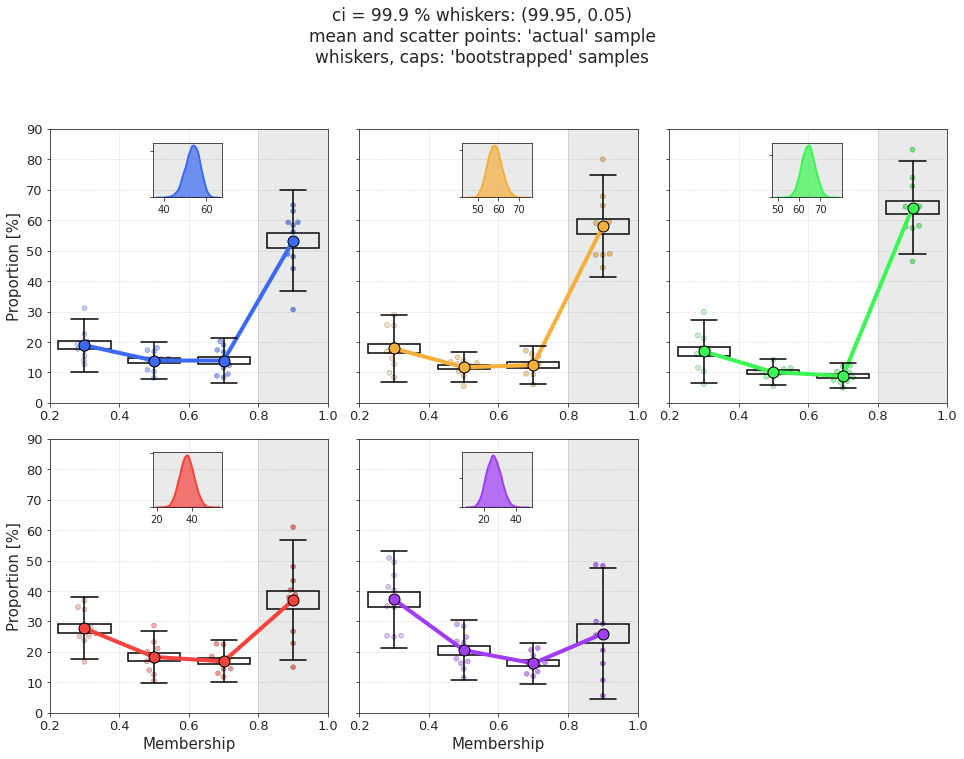

In [49]:
figs, sups, axes, axes_inset = plot_proportions(
    df=gr_bold.mk_boot_df(se_boot, cut_prune_anim),
    inset_data=b_grp_avg[..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig1-pruned_bold-lite_{now()}.pdf"),
)
figs[-1]

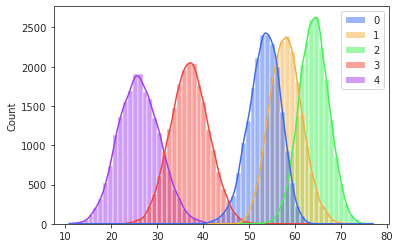

In [50]:
sns.histplot(b_grp_avg[..., -1], palette=gr_bold.colors.values(), kde=True);

### Ca2+

In [51]:
i, j, k = gr_ca.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_ca.cast_votes(se_anim, 0.99, 0.01)

In [52]:
pi_prune = dc(gr_ca.run_pi)
for node in gr_ca.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [53]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_ca.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [54]:
np.round(cut_prune_avg, 1)

array([[18.8, 14.9, 15.1, 51.3],
       [23.4, 17.1, 19.7, 39.8],
       [25.3, 18.7, 16.6, 39.4],
       [27.8, 21. , 19.3, 31.8],
       [31.4, 17.2, 12.4, 38.9]])

In [55]:
b_grp = bootstrap(
    x=cut_prune,
    n_resamples=20000,
    batch=5,
    dims=dims,
    est=None,
)
b_grp_avg = bn.nanmean(bn.nanmean(bn.nanmean(b_grp, 3), 2), 1)

In [56]:
bn.nanmean(b_grp_avg, 0)

array([[18.78935019, 14.8516775 , 15.04907492, 51.30989738],
       [23.45144641, 17.12526878, 19.67653479, 39.74675002],
       [25.24911765, 18.71697836, 16.6092651 , 39.42463889],
       [27.80633131, 21.02483719, 19.34260872, 31.82622279],
       [31.44554378, 17.22341407, 12.43050071, 38.90054144]])

In [57]:
se_boot = bn.nanstd(b_grp_avg, 0, ddof=1)
se_boot

array([[3.04135395, 1.75645348, 1.60932961, 5.19944549],
       [2.03006548, 1.1869673 , 2.5083703 , 4.37417351],
       [2.38653753, 1.62289367, 1.36223507, 3.88318231],
       [2.12162139, 1.36961765, 1.16501999, 3.21714137],
       [2.58953375, 1.65575821, 1.09100252, 3.73247678]])

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig1-pruned_ca2_(2022_02_01).pdf

done.

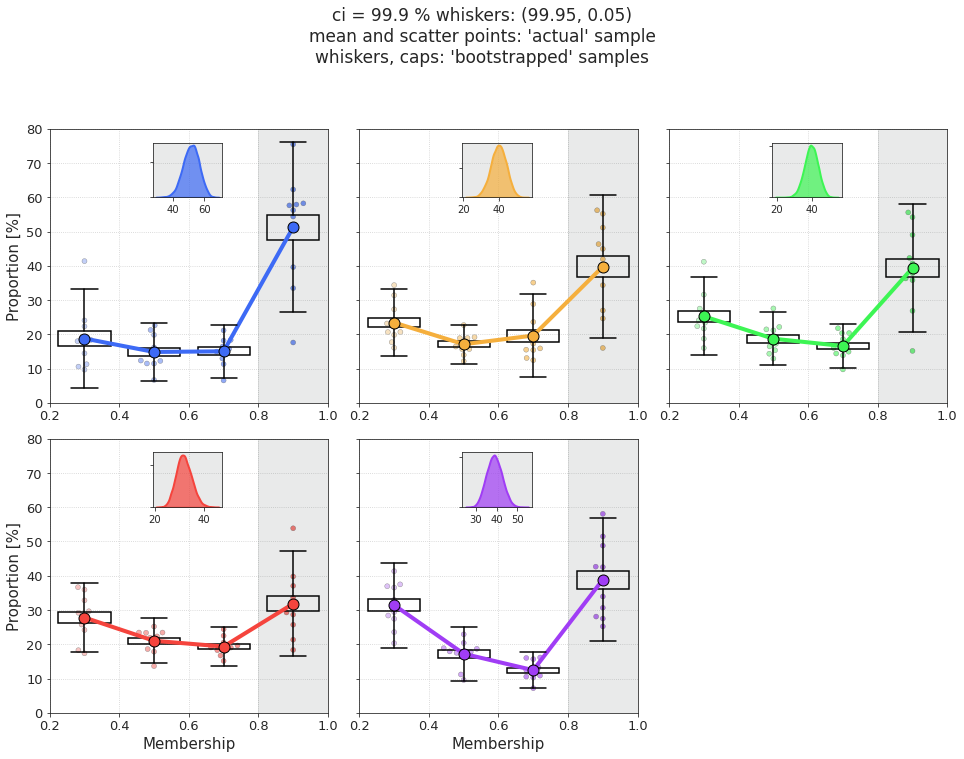

In [58]:
figs, sups, axes, axes_inset = plot_proportions(
    df=gr_ca.mk_boot_df(se_boot, cut_prune_anim),
    inset_data=b_grp_avg[..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig1-pruned_ca2_{now()}.pdf"),
)
figs[-1]

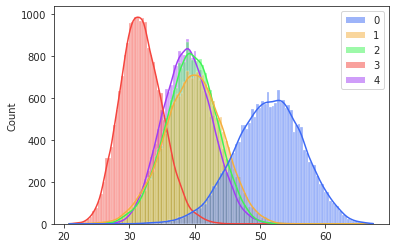

In [59]:
sns.histplot(b_grp_avg[..., -1], palette=gr_ca.colors.values(), kde=True);

## Proportion plot: individual

### BOLD-Lite

In [60]:
i, j, k = gr_bold.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_bold.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_bold.cast_votes(se_anim, 0.99, 0.01)

In [61]:
pi_prune = dc(gr_bold.run_pi)
for node in gr_bold.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [62]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_bold.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [63]:
b_anim = bootstrap(
    x=cut_prune,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)

In [64]:
anim = 3

In [65]:
bn.nanmean(b_anim_avg, 0)[anim]

array([[22.22798734, 14.00791379, 17.51915163, 46.24494724],
       [28.83529269, 10.33449524, 10.80165217, 50.02855991],
       [29.19925868, 11.37898848, 12.13211995, 47.28963289],
       [25.03951218, 16.84466556, 14.70491957, 43.41090268],
       [41.61112915, 17.05016699, 21.19914363, 20.13956023]])

In [66]:
se_boot = bn.nanstd(b_anim_avg, 0, ddof=1)
se_boot[anim]

array([[3.99418985, 1.2144005 , 2.32555376, 4.31381579],
       [4.27093523, 1.5231667 , 2.60098953, 4.42762283],
       [3.58637417, 3.02153697, 1.28891412, 5.34252871],
       [3.36921004, 2.50961159, 1.55320688, 4.21776147],
       [5.90254805, 3.3265734 , 5.82807433, 4.49420405]])

In [67]:
df = gr_bold.mk_boot_df(se_boot, cut_prune_anim)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig1-pruned_sub-SLC04_bold-lite_(2022_02_01).pdf

done.

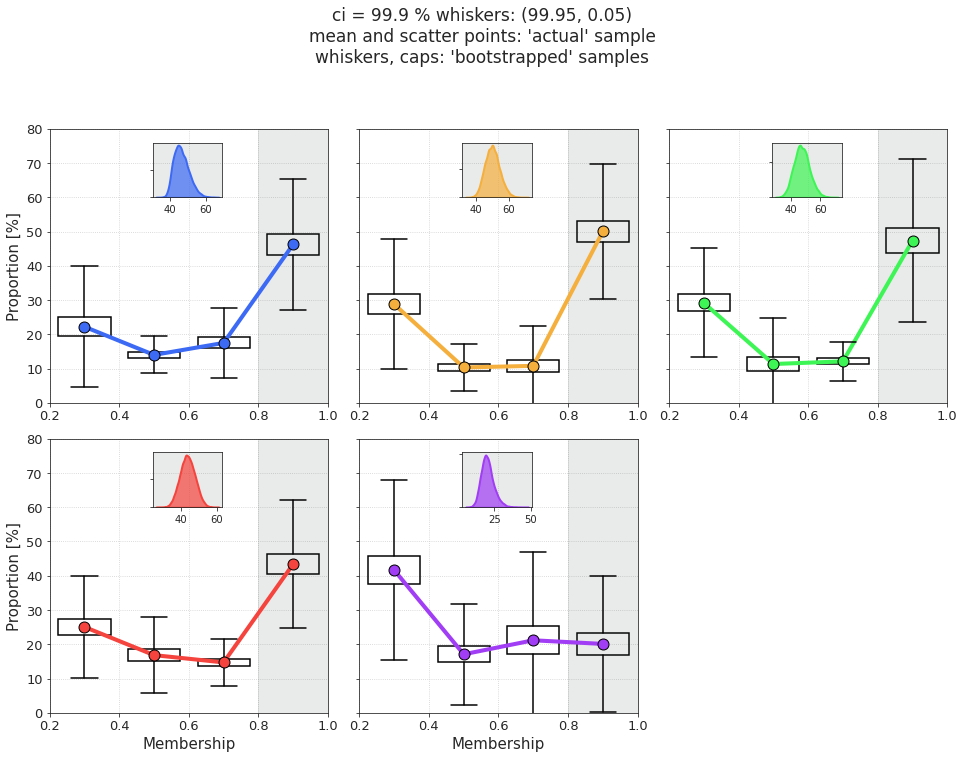

In [68]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df.loc[df['subject'] == anim + 1],
    inset_data=b_anim_avg[:, anim, :, -1].T,
    save_file=pjoin(tmp_dir, f"Fig1-pruned_{mice.get_key(anim + 1)}_bold-lite_{now()}.pdf"),
    ylim=(0, 80),
)
figs[-1]

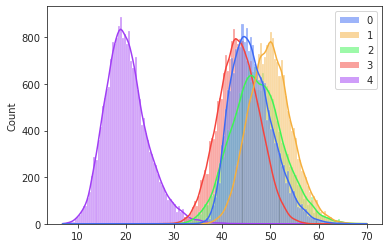

In [69]:
sns.histplot(b_anim_avg[:, anim, :, -1], palette=gr_bold.colors.values(), kde=True);

### Ca2+

In [70]:
i, j, k = gr_ca.run_pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
votes_dict = gr_ca.cast_votes(se_anim, 0.99, 0.01)

In [71]:
pi_prune = dc(gr_ca.run_pi)
for node in gr_ca.n2l:
    for anim in range(i):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, j, axis=0)
        vote = np.repeat(vote, k, axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

In [72]:
kk, nn = pi_prune.shape[-2:]
cut_prune, _ = cut_data(
    data=pi_prune.reshape(-1, kk, nn),
    bins=gr_ca.bins,
    oc_only=True,
)
cut_prune = cut_prune.reshape((*pi_prune.shape[:-2], kk, -1))
cut_prune_anim = bn.nanmean(bn.nanmean(cut_prune, 2), 1)
cut_prune_avg = bn.nanmean(cut_prune_anim, 0)
cut_prune.shape, cut_prune_anim.shape, cut_prune_avg.shape

((10, 3, 4, 5, 4), (10, 5, 4), (5, 4))

In [73]:
b_anim = bootstrap(
    x=cut_prune,
    n_resamples=20000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)

In [74]:
anim = 3

In [75]:
bn.nanmean(b_anim_avg, 0)[anim]

array([[14.32051369, 11.38875864, 15.63612258, 58.65460508],
       [21.05692577, 15.53665123, 12.47566664, 50.93075635],
       [18.63123155, 16.64463273, 14.93712253, 49.78701319],
       [18.60769494, 21.74271023, 20.01181225, 39.63778258],
       [36.71233727, 22.34097674, 13.2529117 , 27.6937743 ]])

In [76]:
se_boot = bn.nanstd(b_anim_avg, 0, ddof=1)
se_boot[anim]

array([[2.89583255, 2.37943658, 3.838372  , 3.66048532],
       [3.623338  , 1.97900872, 1.40582954, 5.07347388],
       [3.93861623, 3.30612712, 2.82447363, 3.94567378],
       [1.75961529, 1.9502682 , 2.78484115, 4.73702589],
       [4.87809374, 4.26631669, 2.74561202, 3.40734457]])

In [77]:
df = gr_ca.mk_boot_df(se_boot, cut_prune_anim)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig1-pruned_sub-SLC04_ca2_(2022_02_01).pdf

done.

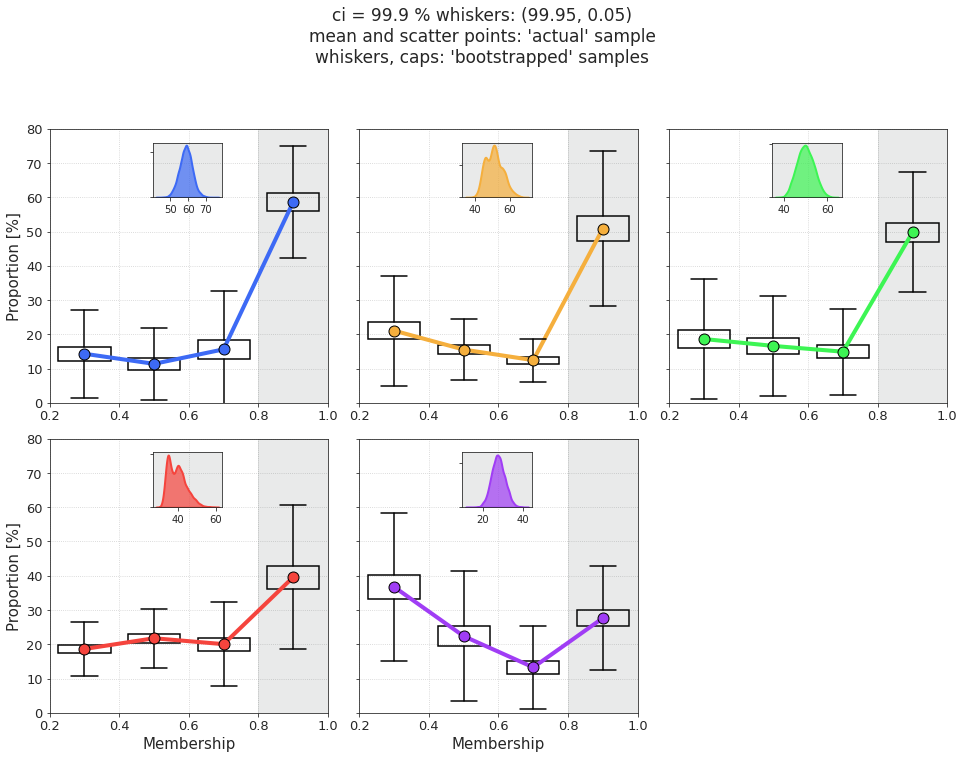

In [78]:
figs, sups, axes, axes_inset = plot_proportions(
    df=df.loc[df['subject'] == anim + 1],
    inset_data=b_anim_avg[:, anim, :, -1].T,
    save_file=pjoin(tmp_dir, f"Fig1-pruned_{mice.get_key(anim + 1)}_ca2_{now()}.pdf"),
    ylim=(0, 80),
)
figs[-1]

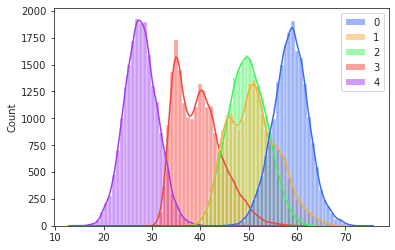

In [79]:
sns.histplot(b_anim_avg[:, anim, :, -1], palette=gr_ca.colors.values(), kde=True);